In [13]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time
import pickle

from datetime import datetime
from pathlib import Path

import math 

#### Import classes

In [14]:
%run "custom_datasets.ipynb"
%run "Model Classes/cnn_model.ipynb"
%run "Model Classes/siren_model.ipynb"

Imported classes.
Imported CNN model.
Imported SIREN model.


In [15]:
def set_device():
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('----------------------------------')
    print('Using device for training:', DEVICE)
    print('----------------------------------')
    
    return DEVICE 

DEVICE = set_device()
# DEVICE = torch.device('cpu')

----------------------------------
Using device for training: cuda
----------------------------------


#### Dataloader

In [4]:
data = PrepareData3D(["Aorta Volunteers", "Aorta BaV", "Aorta Resvcue", "Aorta CoA"], norm_min_max=[0,1])

train_ds = SirenDataset(data.train, DEVICE) 
train_dataloader = DataLoader(train_ds, batch_size=1, num_workers=0)
print(train_ds.__len__())


val_ds = SirenDataset(data.val, DEVICE) 
val_dataloader = DataLoader(val_ds, batch_size=1, num_workers=0)
print(val_ds.__len__())


54
18


#### Load models

In [5]:
cnn = CNN().cuda()

In [6]:
siren = Siren(in_features=131, out_features=1, hidden_features=256, 
              hidden_layers=4, first_different_init=True, 
              outermost_layer="sigmoid").cuda()

In [16]:
siren

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=131, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (5): Linear(in_features=256, out_features=1, bias=True)
    (6): Sigmoid()
  )
)

#### Optimizers & Loss

In [7]:
lr = 2e-4

siren_optim = torch.optim.Adam(lr=lr, params=siren.parameters())
cnn_optim = torch.optim.Adam(lr=lr, params=cnn.parameters())

# def l2_loss(out, ground_truth): 
#     return ((out - ground_truth)**2).mean()

# criterion = l2_loss

criterion = nn.BCELoss()

#####  Random coords subsample

In [8]:
def choose_random_coords(coords, pcmra_array, mask_array, n=1000): 
    mx = coords.shape[1]
    rand_idx = random.sample(range(mx), n)

    coords = coords[:, rand_idx, :]
    pcmra_array = pcmra_array[:, rand_idx, :]
    mask_array = mask_array[:, rand_idx, :]

    return coords, pcmra_array, mask_array

#### Image generation and model saving functions 

In [9]:
def get_complete_image(pcmra, coords, val_n = 10000): 
    
    cnn.eval()
    siren.eval()
    
    image = torch.Tensor([]).cuda()
    
    cnn_out = cnn(pcmra)
    
    n_slices = math.ceil(coords.shape[1] / val_n)    
    for i in range(n_slices):
        s_e = (i * val_n, (i+1) * val_n)
        
        coords_in = coords[:, s_e[0] : s_e[1], :]
        z = cnn_out.unsqueeze(0).repeat(1, coords_in.shape[1], 1)
        siren_in = torch.cat((coords_in, z), 2)

        siren_out = siren(siren_in)
    
        image = torch.cat((image, siren_out.detach()), 1)
    
    cnn.train()
    cnn.train()
    
    return image 


def save_model(best_loss, losses, dataset="train"):
    mean, std = round(np.mean(losses), 6), round(np.std(losses), 6)

    print(f"{dataset} \t mean loss: {mean} \t std: {std}")

    if mean < best_loss: 
        best_loss = mean
        print(f"New best {dataset} loss, saving model.")

        torch.save(cnn.state_dict(), f"Models/{folder}/cnn_{dataset}.pt")
        torch.save(cnn_optim.state_dict(), f"Models/{folder}/cnn_optim_{dataset}.pt")
        
        torch.save(siren.state_dict(), f"Models/{folder}/siren_{dataset}.pt")
        torch.save(siren_optim.state_dict(), f"Models/{folder}/siren_optim_{dataset}.pt")

    return best_loss     

#### Alter optimizers

In [10]:
lr = 2e-4
cnn_optim.param_groups[0]['lr'] = lr
print(cnn_optim)
siren_optim.param_groups[0]['lr'] = lr


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0002
    weight_decay: 0
)


#### Load model

In [11]:
folder = "Models/GON 27-03-2021 14:02:05 mask_complete dataset_lr 0.0002_n 30000/"

best_loss = "train"

cnn.load_state_dict(torch.load(f"{folder}/cnn_{best_loss}.pt"))
cnn_optim.load_state_dict(torch.load(f"{folder}/cnn_optim_{best_loss}.pt"))

siren.load_state_dict(torch.load(f"{folder}/siren_{best_loss}.pt"))
siren_optim.load_state_dict(torch.load(f"{folder}/siren_optim_{best_loss}.pt"))


#### Train model
for pcmra array with linear output, 0.000500 is good.


for mask with sigmoid output and BCE, 0.02 is good. 

In [12]:
epochs = 1
print_every = 10

# n = 393216
n = 30000

output_type = "mask"
dataset = "complete"

now = datetime.now()
dt = now.strftime("%d-%m-%Y %H:%M:%S")

folder = f"{dt} {output_type}_{dataset} dataset_lr {lr}_n {n}"

Path(f"Models/{folder}").mkdir(parents=True, exist_ok=True)   
print(f"Creating path \\Models\\{folder}")
    

best_train_loss, best_val_loss = 100000, 100000

for ep in range(epochs):
    
    t = time.time() 
    
    cnn.train()
    siren.train()

    losses = []
    
    siren_optim.zero_grad()
    cnn_optim.zero_grad()
        
    for idx, subj, proj, pcmra, coords, pcmra_array, mask_array in train_dataloader:
        siren_in, _, siren_labels = choose_random_coords(coords, pcmra_array, mask_array, n=n)

        cnn_out = cnn(pcmra)
        
        cnn_out = cnn_out.unsqueeze(0).repeat(1, n, 1)
        siren_in = torch.cat((siren_in, cnn_out), 2)

        siren_out = siren(siren_in)

        loss = criterion(siren_out, siren_labels) 
        losses.append(loss.item())
        
        loss = loss / train_ds.__len__()
        loss.backward()
    
    siren_optim.step()
    cnn_optim.step()        

    if ep % print_every == 0: 
        
        print(f"Epoch {ep} took {round(time.time() - t)} seconds.")
        
        best_train_loss = save_model(best_train_loss, losses, dataset="train")
        
        val_losses = []
        
        for idx, subj, proj, pcmra, coords, pcmra_array, mask_array in val_dataloader:    
            siren_out = get_complete_image(pcmra, coords)
            loss = criterion(siren_out, mask_array)            
        
            val_losses.append(loss.item())
            
        best_val_loss = save_model(best_val_loss, val_losses, dataset="val")
                
        print()
        

Creating path \Models\29-03-2021 10:04:36 mask_complete dataset_lr 0.0002_n 30000
Epoch 0 took 37 seconds.
train 	 mean loss: 0.026411 	 std: 0.004526
New best train loss, saving model.
val 	 mean loss: 0.085959 	 std: 0.039509
New best val loss, saving model.



#### Show results

16-09-28_126_done1.npy, loss: 0.03474917262792587


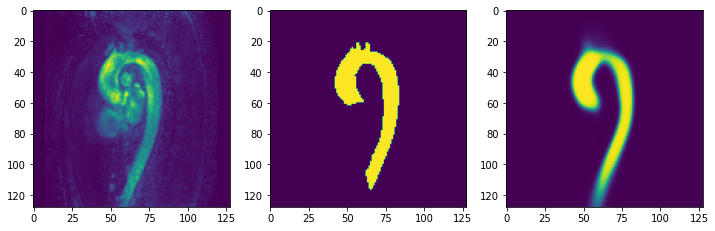

In [47]:
idx, subj, proj, pcmra, coords, pcmra_array, mask_array = train_ds[1]
pcmra, coords = pcmra.unsqueeze(0), coords.unsqueeze(0)
pcmra_array, mask_array =  pcmra_array.unsqueeze(0), mask_array.unsqueeze(0)

siren_out = get_complete_image(pcmra, coords)
loss = criterion(siren_out, mask_array)            

print(f"{subj}, loss: {loss}")

slic = 12

fig, axes = plt.subplots(1, 3, figsize=(12,12))
axes[0].imshow(pcmra_array.cpu().view(128, 128, 24).detach().numpy()[:, :, slic])
axes[1].imshow(mask_array.cpu().view(128, 128, 24).detach().numpy()[:, :, slic])
axes[2].imshow(siren_out.cpu().view(128, 128, 24).detach().numpy()[:, :, slic])
# axes[2].imshow(siren_out.cpu().view(128, 128, 24).detach().numpy().round()[:, :, slic])

plt.show()

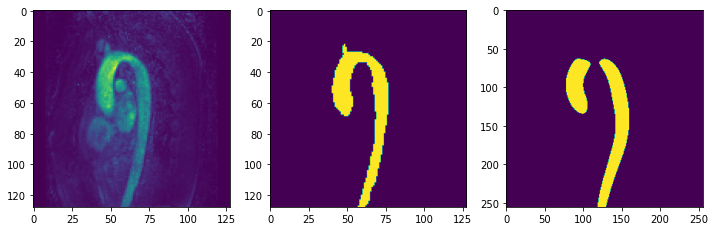

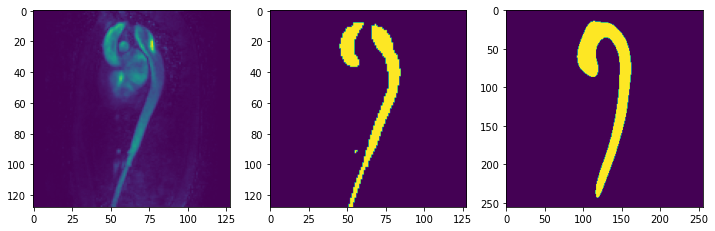

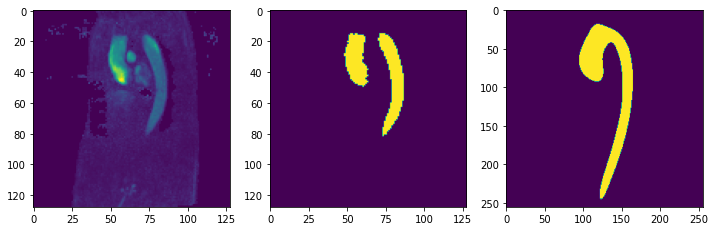

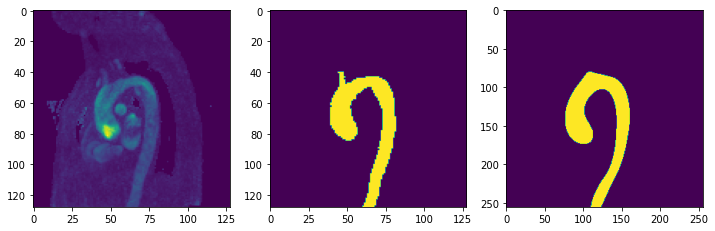

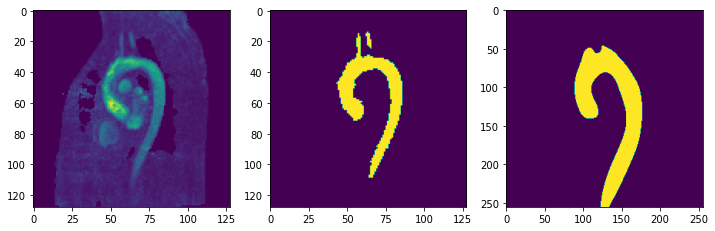

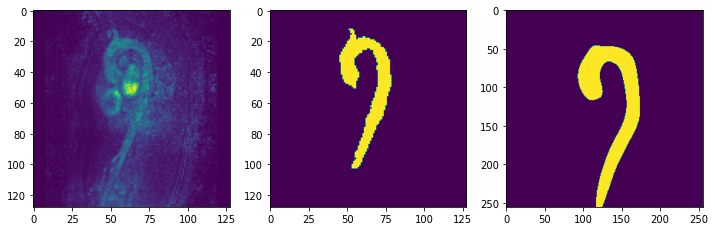

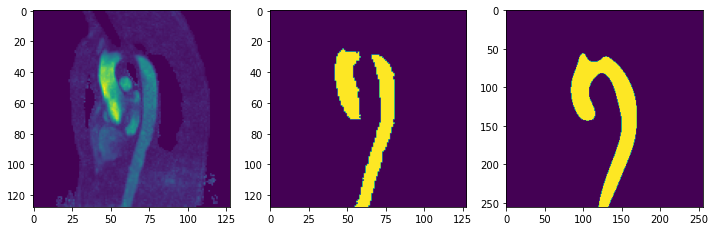

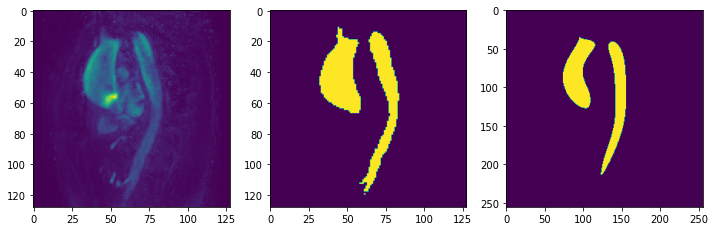

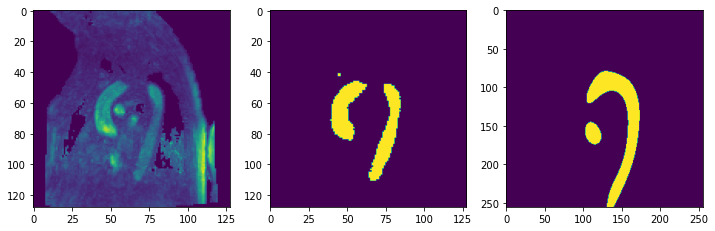

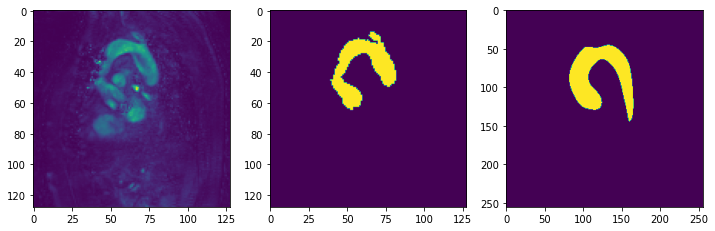

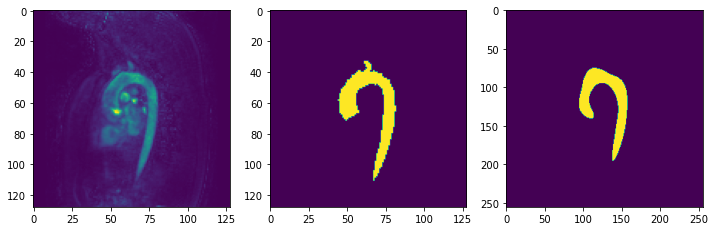

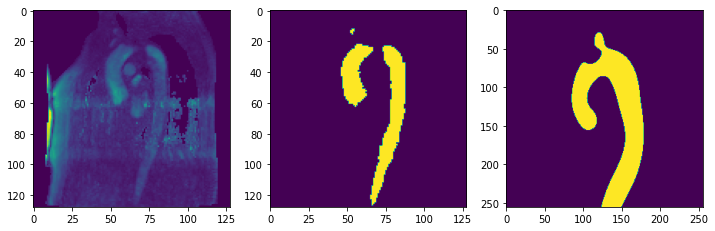

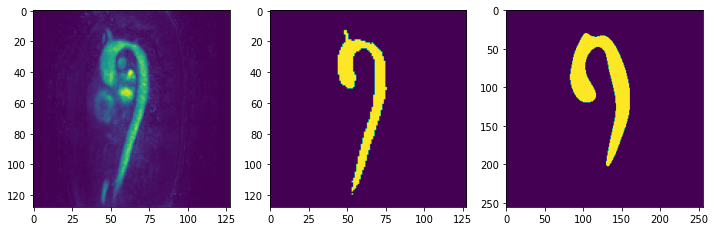

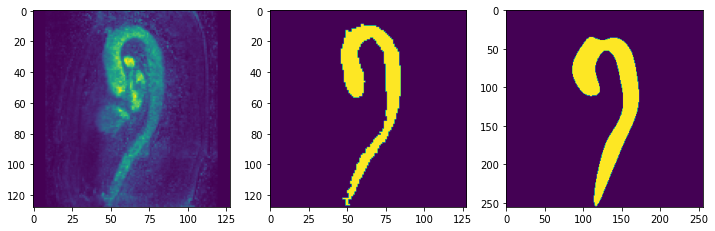

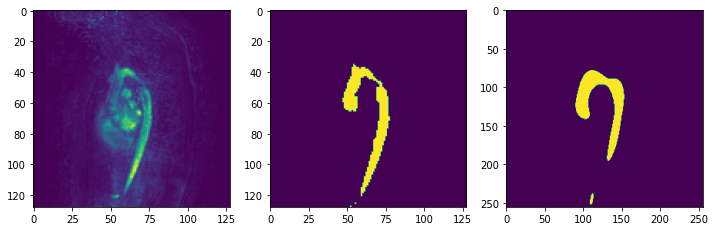

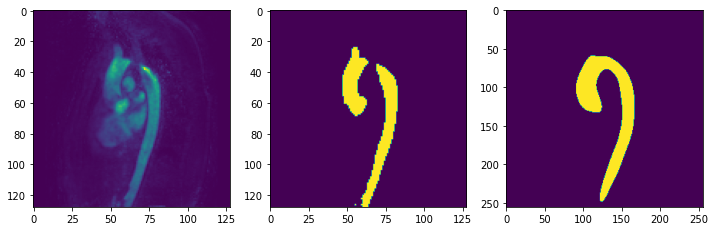

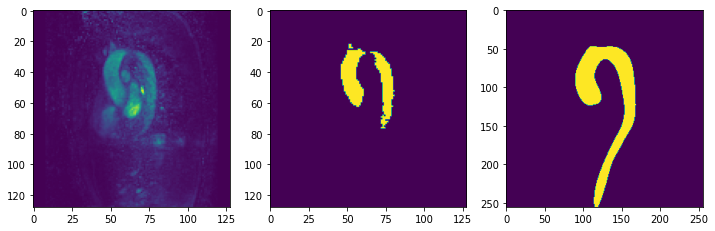

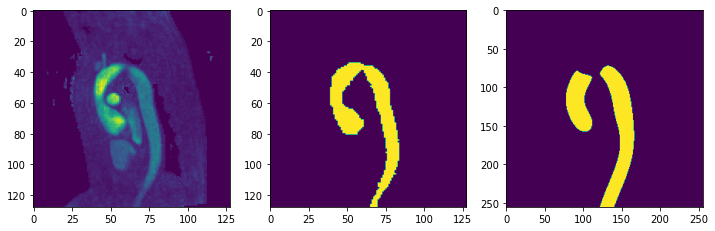

In [32]:
for idx, subj, proj, pcmra, _, pcmra_array, mask_array in val_dataloader: 
    
    
    siren_out = get_complete_image(pcmra, coords)
#     loss = criterion(siren_out, mask_array)            

#     print(subj, loss.item()) 

    slic = 12

    fig, axes = plt.subplots(1, 3, figsize=(12,12))
    axes[0].imshow(pcmra_array.cpu().view(128, 128, 24).detach().numpy()[:, :, slic])
    axes[1].imshow(mask_array.cpu().view(128, 128, 24).detach().numpy()[:, :, slic])
    axes[2].imshow(siren_out.cpu().view(256, 256, 48).detach().numpy().round()[:, :, slic*2])

    plt.show()

In [19]:
def get_coords(*sidelengths):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    
    tensors = []
    
    for sidelen in sidelengths:
        tensors.append(torch.linspace(-1, 1, steps=sidelen))
    
    tensors = tuple(tensors)
    coords = torch.stack(torch.meshgrid(*tensors), dim=-1)
    return coords.reshape(-1, len(sidelengths))

In [28]:
coords = get_coords(256, 256, 48)

print(coords.shape)

torch.Size([3145728, 3])


In [29]:
coords = coords.unsqueeze(0).cuda()

In [30]:
print(coords[:, :10, :])

tensor([[[-1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -0.9574],
         [-1.0000, -1.0000, -0.9149],
         [-1.0000, -1.0000, -0.8723],
         [-1.0000, -1.0000, -0.8298],
         [-1.0000, -1.0000, -0.7872],
         [-1.0000, -1.0000, -0.7447],
         [-1.0000, -1.0000, -0.7021],
         [-1.0000, -1.0000, -0.6596],
         [-1.0000, -1.0000, -0.6170]]], device='cuda:0')
